# Librerias

In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

import os
import io
import json
import warnings
from datetime import date

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.grid"] = True


# Token

In [8]:
# Coloca tu token personal de Banxico
BANXICO_TOKEN = "caa9ce3af73a7040c54f64908e2af98fd965b7c816828c6d90836ff2dd38a9d2"

serie_id = "SF43783"  # ID de la TIIE a 28 días
url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie_id}/datos"

headers = {"Bmx-Token": BANXICO_TOKEN}
response = requests.get(url, headers=headers)
data = response.json()

# Convertir a DataFrame
datos = data['bmx']['series'][0]['datos']
df = pd.DataFrame(datos)
df['fecha'] = pd.to_datetime(df['fecha'])
df['dato'] = pd.to_numeric(df['dato'], errors='coerce')
df = df.set_index('fecha').sort_index()
df.rename(columns={"dato": "TIIE_28d"}, inplace=True)
# Trabajar sin datos faltantes
df = df.asfreq("D")
df["TIIE_28d"].fillna(method="ffill", inplace=True)

df
     

,TIIE_28d
fecha,
1995-03-23,90.5000
1995-03-24,90.5000
1995-03-25,90.5000
1995-03-26,90.5000
1995-03-27,90.5000
...,...
2025-09-14,8.0126
2025-09-15,8.0126
2025-09-16,8.0126


In [10]:
df.isna().sum()


TIIE_28d    0
dtype: int64

# Analisis basico

In [12]:
print("=== Resumen estadístico ===")
print(df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
print("\n=== Valores únicos ===")
print(df.nunique())

=== Resumen estadístico ===
           TIIE_28d
count  11138.000000
mean      11.136431
std       10.528987
min        3.274100
1%         3.293200
5%         3.418625
50%        7.860000
95%       34.236750
99%       52.840550
max       90.500000

=== Valores únicos ===
TIIE_28d    4148
dtype: int64


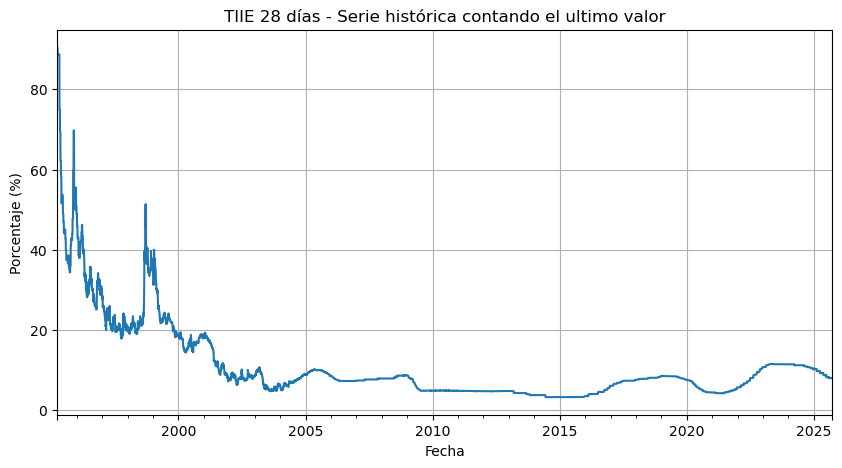

In [18]:
# 2. Visualización de la serie
df["TIIE_28d"].plot(title="TIIE 28 días - Serie histórica contando el ultimo valor")
plt.xlabel("Fecha")
plt.ylabel("Porcentaje (%)")
plt.show()


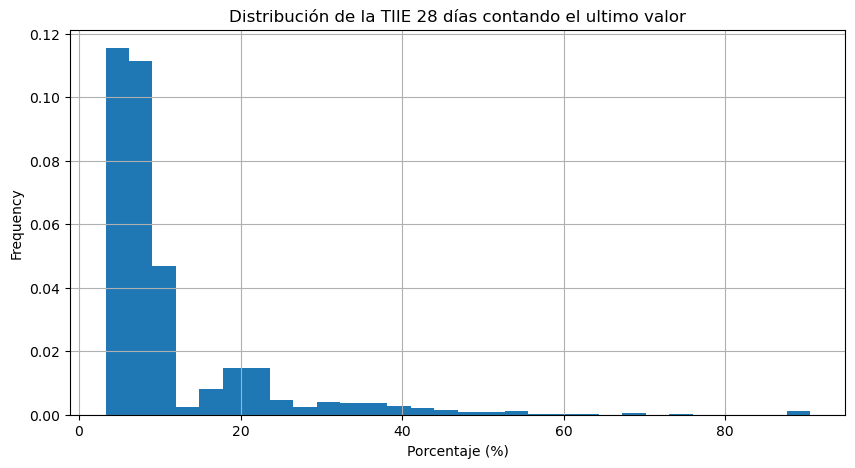

In [20]:
# Histograma
df["TIIE_28d"].plot(kind="hist", bins=30, density=True, title="Distribución de la TIIE 28 días contando el ultimo valor")
plt.xlabel("Porcentaje (%)")
plt.show()

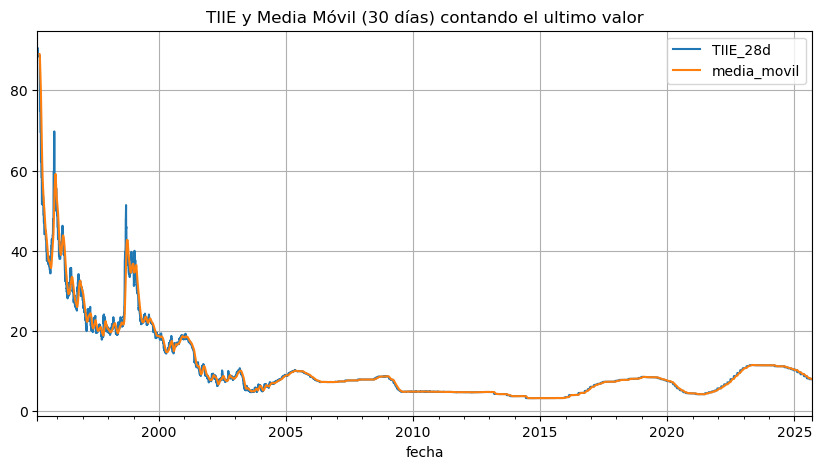

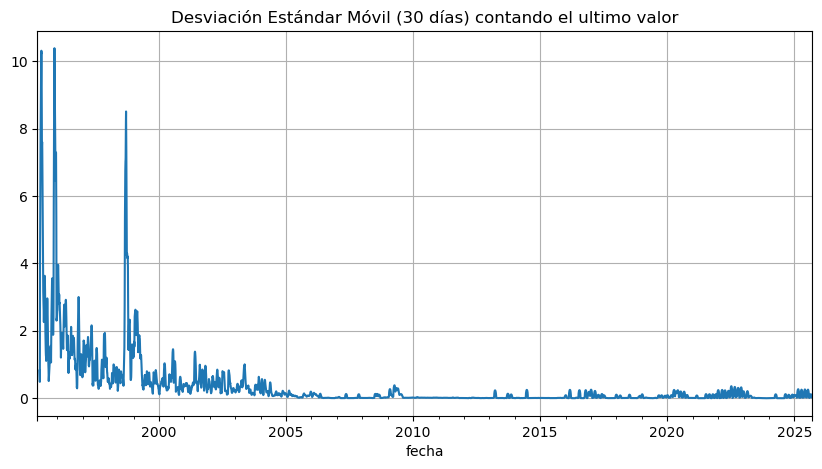

In [21]:
# 3. Medias y volatilidad móviles
window = 30  # ~1 mes hábil
df["media_movil"] = df["TIIE_28d"].rolling(window).mean()
df["std_movil"] = df["TIIE_28d"].rolling(window).std()

df[["TIIE_28d","media_movil"]].plot(title=f"TIIE y Media Móvil ({window} días) contando el ultimo valor")
plt.show()

df["std_movil"].plot(title=f"Desviación Estándar Móvil ({window} días) contando el ultimo valor")
plt.show()


In [16]:
# 4. Pruebas de estacionariedad

def adf_test(series):
    result = adfuller(series.dropna())
    print("\n=== Prueba ADF ===")
    print(f"Estadístico ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Valores críticos:")
    for key, val in result[4].items():
        print(f"   {key}: {val}")

def kpss_test(series):
    statistic, p_value, n_lags, crit_vals = kpss(series.dropna(), regression="c", nlags="auto")
    print("\n=== Prueba KPSS ===")
    print(f"Estadístico KPSS: {statistic}")
    print(f"p-value: {p_value}")
    print("Valores críticos:")
    for key, val in crit_vals.items():
        print(f"   {key}: {val}")

adf_test(df["TIIE_28d"])
kpss_test(df["TIIE_28d"])


=== Prueba ADF ===
Estadístico ADF: -5.998047758729853
p-value: 1.6830908102268328e-07
Valores críticos:
   1%: -3.4309392093289435
   5%: -2.8618003983183495
   10%: -2.5669086049040866

=== Prueba KPSS ===
Estadístico KPSS: 7.643220143569327
p-value: 0.01
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


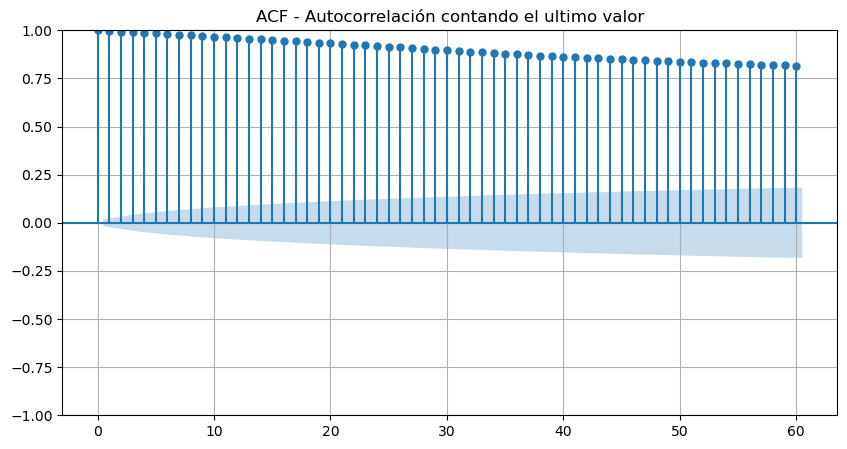

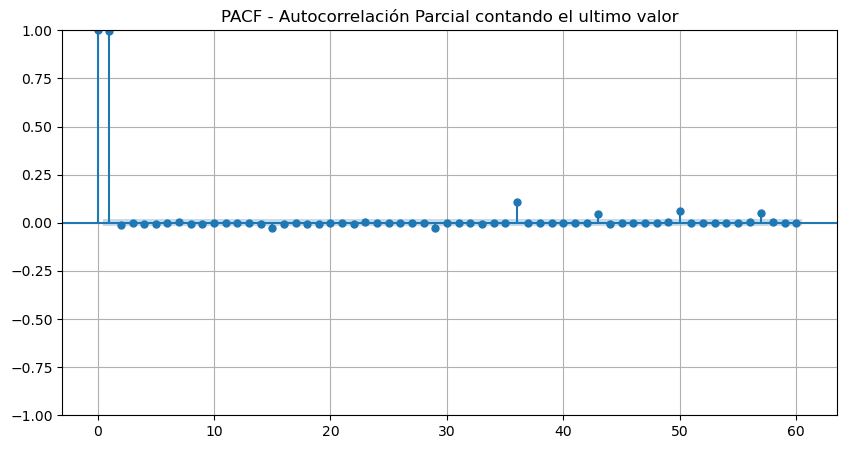

In [22]:
# 5. ACF y PACF

plot_acf(df["TIIE_28d"].dropna(), lags=60)
plt.title("ACF - Autocorrelación contando el ultimo valor")
plt.show()

plot_pacf(df["TIIE_28d"].dropna(), lags=60, method="ywm")
plt.title("PACF - Autocorrelación Parcial contando el ultimo valor")
plt.show()